In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

import geopandas as gpd
import numpy as np
import torch
import torch.nn as nn

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    'mathtext.default': 'regular',
    'text.latex.preamble': r'\usepackage{mathrsfs}'
    })


In [2]:
physical_extent_wrf = {
    # lon min, lon max, lat min, lat max
    "southeast":[-86.55435944, -74.64796448, 21.13699913, 33.04325104],
}

In [3]:
cultural = gpd.read_file("/workspace/Annau2023/data/shapefiles/ne_10m_admin_0_countries.shp")
cultural = cultural[((cultural.ADMIN == "Bahamas") | (cultural.ADMIN == "Canada") | (cultural.ADMIN == "United States of America") | (cultural.ADMIN == "Cuba") | (cultural.ADMIN == "Mexico"))].boundary
lakes = gpd.read_file("/workspace/Annau2023/data/shapefiles/ne_10m_lakes.shp")
lakes = lakes[lakes.scalerank <= 2].boundary
shape = cultural.geometry.append(lakes.geometry)

In [4]:
idx = 31
field = torch.load("/workspace/Annau2023/data/nfs_pfs/hr_test_southeast.pt")

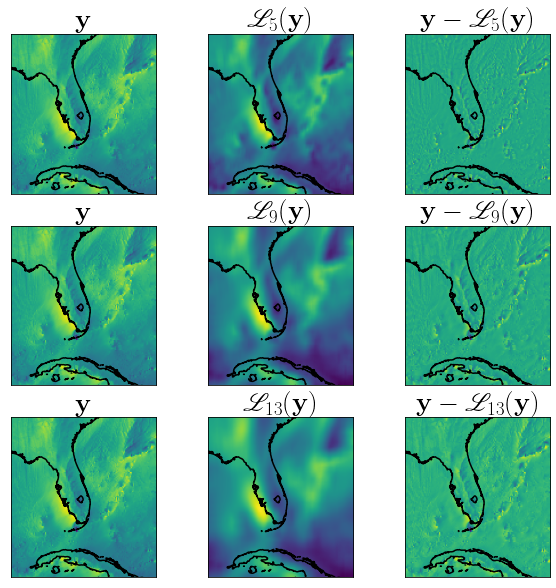

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
cmap = "viridis"

def lowpass(field, N):
    low = nn.AvgPool2d(N, stride=1, padding=0)
    reflect = nn.ReplicationPad2d(N//2)
    return low(reflect(field))

fields = {
    "full_5": field[idx, 0, ...],
    "full_9": field[idx, 0, ...],
    "full_13": field[idx, 0, ...],
    "L_5": lowpass(field, 5)[idx, 0, ...],
    "L_9": lowpass(field, 9)[idx, 0, ...],
    "L_13": lowpass(field, 13)[idx, 0, ...],
    "H_5": field[idx, 0, ...] - lowpass(field, 5)[idx, 0, ...],
    "H_9": field[idx, 0, ...] - lowpass(field, 9)[idx, 0, ...],
    "H_13": field[idx, 0, ...] - lowpass(field, 13)[idx, 0, ...],
}

titlemap = {
    "full_5": r"$\textbf{{y}}$",
    "full_9": r"$\textbf{{y}}$",
    "full_13": r"$\textbf{{y}}$",
    "L_5": r"$\mathscr{{L}}_5(\textbf{{y}})$",
    "L_9": r"$\mathscr{{L}}_9(\textbf{{y}})$",
    "L_13": r"$\mathscr{{L}}_{13}(\textbf{{y}})$",
    "H_5": r"$\textbf{{y}} - \mathscr{{L}}_5(\textbf{{y}})$",
    "H_9": r"$\textbf{{y}} - \mathscr{{L}}_9(\textbf{{y}})$",
    "H_13": r"$\textbf{{y}} - \mathscr{{L}}_{13}(\textbf{{y}})$",
}

for x, ax in zip(fields, axes.T.flat):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(physical_extent_wrf["southeast"][0], physical_extent_wrf["southeast"][1])
    ax.set_ylim(physical_extent_wrf["southeast"][2], physical_extent_wrf["southeast"][3])
    ax.set_title(titlemap[x], fontsize=27)
    ax.imshow(fields[x].cpu().numpy(), origin="lower", cmap=cmap, extent=physical_extent_wrf["southeast"])
    shape.plot(ax=ax, color="black")
